# Task 1: Introduction

---

For this project, we are going to work on evaluating price of houses given the following features:

1. Year of sale of the house
2. The age of the house at the time of sale
3. Distance from city center
4. Number of stores in the locality
5. The latitude
6. The longitude

![Regression](images/regression.png)

Note: This notebook uses `python 3` and these packages: `tensorflow`, `pandas`, `matplotlib`, `scikit-learn`.

## 1.1: Importing Libraries & Helper Functions

First of all, we will need to import some libraries and helper functions. This includes TensorFlow and some utility functions that I've written to save time.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

%matplotlib inline
#tf.logging.set_verbosity(tf.logging.ERROR)

print('Libraries imported.')

Libraries imported.


# Task 2: Importing the Data

## 2.1: Importing the Data

The dataset is saved in a `data.csv` file. We will use `pandas` to take a look at some of the rows.

In [2]:
df = pd.read_csv('data.csv', names = column_names) 
df.head()

,serial,date,age,distance,stores,latitude,longitude,price
0,0,2009,21,9,6,84,121,14264
1,1,2007,4,2,3,86,121,12032
2,2,2016,18,3,7,90,120,13560
3,3,2002,13,2,2,80,128,12029
4,4,2014,25,5,8,81,122,14157


## 2.2: Check Missing Data

It's a good practice to check if the data has any missing values. In real world data, this is quite common and must be taken care of before any data pre-processing or model training.

In [3]:
df.isna().sum()

serial       0
date         0
age          0
distance     0
stores       0
latitude     0
longitude    0
price        0
dtype: int64

# Task 3: Data Normalization

## 3.1: Data Normalization

We can make it easier for optimization algorithms to find minimas by normalizing the data before training a model.

In [4]:
df = df.iloc[:,1:]
df_norm = (df - df.mean()) / df.std()
df_norm.head()

,date,age,distance,stores,latitude,longitude,price
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799,0.350088
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799,-1.836486
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456,-0.339584
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803,-1.839425
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141,0.245266


## 3.2: Convert Label Value

Because we are using normalized values for the labels, we will get the predictions back from a trained model in the same distribution. So, we need to convert the predicted values back to the original distribution if we want predicted prices.

In [5]:
y_mean = df['price'].mean()
y_std = df['price'].std()

def convert_label_value(pred):
    return int(pred * y_std + y_mean)

print(convert_label_value(0.350088))

14263


# Task 4: Create Training and Test Sets

## 4.1: Select Features

Make sure to remove the column __price__ from the list of features as it is the label and should not be used as a feature.

In [6]:
X = df_norm.iloc[:, :6]
X.head()

,date,age,distance,stores,latitude,longitude
0,0.015978,0.181384,1.257002,0.345224,-0.307212,-1.260799
1,-0.350485,-1.319118,-0.930610,-0.609312,0.325301,-1.260799
2,1.298598,-0.083410,-0.618094,0.663402,1.590328,-1.576456
3,-1.266643,-0.524735,-0.930610,-0.927491,-1.572238,0.948803
4,0.932135,0.534444,0.006938,0.981581,-1.255981,-0.945141


## 4.2: Select Labels

In [7]:
Y = df_norm.iloc[:, -1]
Y.head()

0    0.350088
1   -1.836486
2   -0.339584
3   -1.839425
4    0.245266
Name: price, dtype: float64

## 4.3: Feature and Label Values

We will need to extract just the numeric values for the features and labels as the TensorFlow model will expect just numeric values as input.

In [8]:
X_arr = X.values
Y_arr = Y.values

print('X_arr shape: ', X_arr.shape)
print('Y_arr shape: ', Y_arr.shape)

X_arr shape:  (5000, 6)
Y_arr shape:  (5000,)


## 4.4: Train and Test Split

We will keep some part of the data aside as a __test__ set. The model will not use this set during training and it will be used only for checking the performance of the model in trained and un-trained states. This way, we can make sure that we are going in the right direction with our model training.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, test_size = 0.05, shuffle = True, random_state=0)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (4750, 6)
y_train shape:  (4750,)
X_test shape:  (250, 6)
y_test shape:  (250,)


# Task 5: Create the Model

## 5.1: Create the Model

Let's write a function that returns an untrained model of a certain architecture.

In [10]:
def get_model():
    
    model = Sequential([
        Dense(10, input_shape = (6,), activation = 'relu'),
        Dense(20, activation = 'relu'),
        Dense(5, activation = 'relu'),
        Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer='adadelta'
    )
    
    return model

model = get_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                70        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


# Task 6: Model Training

## 6.1: Model Training

We can use an `EarlyStopping` callback from Keras to stop the model training if the validation loss stops decreasing for a few epochs.

In [11]:
early_stopping = EarlyStopping(monitor='val_loss', patience = 5)

model = get_model()

preds_on_untrained = model.predict(X_test)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 1000,
    callbacks = [early_stopping]
)

Train on 4750 samples, validate on 250 samples
Epoch 1/1000
4750/4750 [==============================] - 0s 75us/sample - loss: 1.0126 - val_loss: 0.8512
Epoch 2/1000
4750/4750 [==============================] - 0s 26us/sample - loss: 1.0114 - val_loss: 0.8502
Epoch 3/1000
4750/4750 [==============================] - 0s 30us/sample - loss: 1.0104 - val_loss: 0.8492
Epoch 4/1000
4750/4750 [==============================] - 0s 26us/sample - loss: 1.0094 - val_loss: 0.8482
Epoch 5/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 1.0083 - val_loss: 0.8472
Epoch 6/1000
4750/4750 [==============================] - 0s 26us/sample - loss: 1.0074 - val_loss: 0.8463
Epoch 7/1000
4750/4750 [==============================] - 0s 26us/sample - loss: 1.0064 - val_loss: 0.8453
Epoch 8/1000
4750/4750 [==============================] - 0s 25us/sample - loss: 1.0054 - val_loss: 0.8444
Epoch 9/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 1.0044 - val_los

4750/4750 [==============================] - 0s 23us/sample - loss: 0.9440 - val_loss: 0.7849
Epoch 77/1000
4750/4750 [==============================] - 0s 23us/sample - loss: 0.9431 - val_loss: 0.7841
Epoch 78/1000
4750/4750 [==============================] - 0s 23us/sample - loss: 0.9423 - val_loss: 0.7832
Epoch 79/1000
4750/4750 [==============================] - 0s 23us/sample - loss: 0.9414 - val_loss: 0.7824
Epoch 80/1000
4750/4750 [==============================] - 0s 23us/sample - loss: 0.9405 - val_loss: 0.7816
Epoch 81/1000
4750/4750 [==============================] - 0s 23us/sample - loss: 0.9396 - val_loss: 0.7807
Epoch 82/1000
4750/4750 [==============================] - 0s 23us/sample - loss: 0.9388 - val_loss: 0.7799
Epoch 83/1000
4750/4750 [==============================] - 0s 23us/sample - loss: 0.9379 - val_loss: 0.7791
Epoch 84/1000
4750/4750 [==============================] - 0s 23us/sample - loss: 0.9370 - val_loss: 0.7783
Epoch 85/1000
4750/4750 [=================

4750/4750 [==============================] - 0s 24us/sample - loss: 0.8789 - val_loss: 0.7234
Epoch 152/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.8780 - val_loss: 0.7226
Epoch 153/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.8771 - val_loss: 0.7218
Epoch 154/1000
4750/4750 [==============================] - 0s 27us/sample - loss: 0.8763 - val_loss: 0.7210
Epoch 155/1000
4750/4750 [==============================] - 0s 26us/sample - loss: 0.8754 - val_loss: 0.7201
Epoch 156/1000
4750/4750 [==============================] - 0s 26us/sample - loss: 0.8745 - val_loss: 0.7193
Epoch 157/1000
4750/4750 [==============================] - 0s 26us/sample - loss: 0.8736 - val_loss: 0.7185
Epoch 158/1000
4750/4750 [==============================] - 0s 26us/sample - loss: 0.8727 - val_loss: 0.7176
Epoch 159/1000
4750/4750 [==============================] - 0s 26us/sample - loss: 0.8718 - val_loss: 0.7168
Epoch 160/1000
4750/4750 [========

4750/4750 [==============================] - 0s 25us/sample - loss: 0.8103 - val_loss: 0.6597
Epoch 227/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.8094 - val_loss: 0.6588
Epoch 228/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.8084 - val_loss: 0.6579
Epoch 229/1000
4750/4750 [==============================] - 0s 27us/sample - loss: 0.8075 - val_loss: 0.6570
Epoch 230/1000
4750/4750 [==============================] - 0s 27us/sample - loss: 0.8066 - val_loss: 0.6562
Epoch 231/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.8056 - val_loss: 0.6553
Epoch 232/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.8047 - val_loss: 0.6544
Epoch 233/1000
4750/4750 [==============================] - 0s 25us/sample - loss: 0.8037 - val_loss: 0.6535
Epoch 234/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.8028 - val_loss: 0.6527
Epoch 235/1000
4750/4750 [========

4750/4750 [==============================] - 0s 24us/sample - loss: 0.7368 - val_loss: 0.5915
Epoch 302/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.7358 - val_loss: 0.5906
Epoch 303/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.7348 - val_loss: 0.5896
Epoch 304/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.7338 - val_loss: 0.5887
Epoch 305/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.7328 - val_loss: 0.5878
Epoch 306/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.7318 - val_loss: 0.5869
Epoch 307/1000
4750/4750 [==============================] - 0s 23us/sample - loss: 0.7308 - val_loss: 0.5859
Epoch 308/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.7298 - val_loss: 0.5850
Epoch 309/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.7288 - val_loss: 0.5841
Epoch 310/1000
4750/4750 [========

4750/4750 [==============================] - 0s 25us/sample - loss: 0.6603 - val_loss: 0.5211
Epoch 377/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.6593 - val_loss: 0.5201
Epoch 378/1000
4750/4750 [==============================] - 0s 27us/sample - loss: 0.6582 - val_loss: 0.5192
Epoch 379/1000
4750/4750 [==============================] - 0s 25us/sample - loss: 0.6572 - val_loss: 0.5183
Epoch 380/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.6562 - val_loss: 0.5174
Epoch 381/1000
4750/4750 [==============================] - 0s 27us/sample - loss: 0.6551 - val_loss: 0.5165
Epoch 382/1000
4750/4750 [==============================] - 0s 25us/sample - loss: 0.6541 - val_loss: 0.5156
Epoch 383/1000
4750/4750 [==============================] - 0s 26us/sample - loss: 0.6531 - val_loss: 0.5146
Epoch 384/1000
4750/4750 [==============================] - 0s 26us/sample - loss: 0.6520 - val_loss: 0.5137
Epoch 385/1000
4750/4750 [========

4750/4750 [==============================] - 0s 24us/sample - loss: 0.5821 - val_loss: 0.4547
Epoch 452/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.5811 - val_loss: 0.4539
Epoch 453/1000
4750/4750 [==============================] - 0s 25us/sample - loss: 0.5800 - val_loss: 0.4530
Epoch 454/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.5789 - val_loss: 0.4521
Epoch 455/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.5779 - val_loss: 0.4512
Epoch 456/1000
4750/4750 [==============================] - 0s 23us/sample - loss: 0.5769 - val_loss: 0.4503
Epoch 457/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.5758 - val_loss: 0.4494
Epoch 458/1000
4750/4750 [==============================] - 0s 26us/sample - loss: 0.5748 - val_loss: 0.4486
Epoch 459/1000
4750/4750 [==============================] - 0s 26us/sample - loss: 0.5737 - val_loss: 0.4477
Epoch 460/1000
4750/4750 [========

4750/4750 [==============================] - 0s 24us/sample - loss: 0.5055 - val_loss: 0.3916
Epoch 527/1000
4750/4750 [==============================] - 0s 25us/sample - loss: 0.5045 - val_loss: 0.3908
Epoch 528/1000
4750/4750 [==============================] - 0s 25us/sample - loss: 0.5034 - val_loss: 0.3899
Epoch 529/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.5024 - val_loss: 0.3891
Epoch 530/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.5014 - val_loss: 0.3883
Epoch 531/1000
4750/4750 [==============================] - 0s 25us/sample - loss: 0.5004 - val_loss: 0.3875
Epoch 532/1000
4750/4750 [==============================] - 0s 25us/sample - loss: 0.4994 - val_loss: 0.3866
Epoch 533/1000
4750/4750 [==============================] - 0s 23us/sample - loss: 0.4984 - val_loss: 0.3858
Epoch 534/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.4973 - val_loss: 0.3850
Epoch 535/1000
4750/4750 [========

4750/4750 [==============================] - 0s 23us/sample - loss: 0.4350 - val_loss: 0.3360
Epoch 602/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.4342 - val_loss: 0.3354
Epoch 603/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.4334 - val_loss: 0.3348
Epoch 604/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.4325 - val_loss: 0.3341
Epoch 605/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.4316 - val_loss: 0.3335
Epoch 606/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.4308 - val_loss: 0.3328
Epoch 607/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.4299 - val_loss: 0.3322
Epoch 608/1000
4750/4750 [==============================] - 0s 25us/sample - loss: 0.4291 - val_loss: 0.3316
Epoch 609/1000
4750/4750 [==============================] - 0s 25us/sample - loss: 0.4282 - val_loss: 0.3309
Epoch 610/1000
4750/4750 [========

4750/4750 [==============================] - 0s 23us/sample - loss: 0.3753 - val_loss: 0.2926
Epoch 677/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.3746 - val_loss: 0.2920
Epoch 678/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.3739 - val_loss: 0.2915
Epoch 679/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.3731 - val_loss: 0.2910
Epoch 680/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.3724 - val_loss: 0.2905
Epoch 681/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.3717 - val_loss: 0.2899
Epoch 682/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.3710 - val_loss: 0.2894
Epoch 683/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.3703 - val_loss: 0.2889
Epoch 684/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.3696 - val_loss: 0.2884
Epoch 685/1000
4750/4750 [========

4750/4750 [==============================] - 0s 24us/sample - loss: 0.3285 - val_loss: 0.2600
Epoch 752/1000
4750/4750 [==============================] - 0s 23us/sample - loss: 0.3280 - val_loss: 0.2597
Epoch 753/1000
4750/4750 [==============================] - 0s 23us/sample - loss: 0.3275 - val_loss: 0.2593
Epoch 754/1000
4750/4750 [==============================] - 0s 23us/sample - loss: 0.3270 - val_loss: 0.2590
Epoch 755/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.3264 - val_loss: 0.2586
Epoch 756/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.3259 - val_loss: 0.2583
Epoch 757/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.3254 - val_loss: 0.2579
Epoch 758/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.3249 - val_loss: 0.2576
Epoch 759/1000
4750/4750 [==============================] - 0s 23us/sample - loss: 0.3244 - val_loss: 0.2573
Epoch 760/1000
4750/4750 [========

4750/4750 [==============================] - 0s 24us/sample - loss: 0.2956 - val_loss: 0.2392
Epoch 827/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.2953 - val_loss: 0.2390
Epoch 828/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.2949 - val_loss: 0.2388
Epoch 829/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.2946 - val_loss: 0.2386
Epoch 830/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.2942 - val_loss: 0.2383
Epoch 831/1000
4750/4750 [==============================] - 0s 23us/sample - loss: 0.2938 - val_loss: 0.2381
Epoch 832/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.2935 - val_loss: 0.2379
Epoch 833/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.2931 - val_loss: 0.2377
Epoch 834/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.2928 - val_loss: 0.2375
Epoch 835/1000
4750/4750 [========

4750/4750 [==============================] - 0s 25us/sample - loss: 0.2732 - val_loss: 0.2258
Epoch 902/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.2730 - val_loss: 0.2256
Epoch 903/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.2727 - val_loss: 0.2255
Epoch 904/1000
4750/4750 [==============================] - 0s 23us/sample - loss: 0.2725 - val_loss: 0.2253
Epoch 905/1000
4750/4750 [==============================] - 0s 25us/sample - loss: 0.2722 - val_loss: 0.2252
Epoch 906/1000
4750/4750 [==============================] - 0s 26us/sample - loss: 0.2720 - val_loss: 0.2251
Epoch 907/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.2718 - val_loss: 0.2249
Epoch 908/1000
4750/4750 [==============================] - 0s 25us/sample - loss: 0.2715 - val_loss: 0.2248
Epoch 909/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.2713 - val_loss: 0.2247
Epoch 910/1000
4750/4750 [========

4750/4750 [==============================] - 0s 24us/sample - loss: 0.2574 - val_loss: 0.2168
Epoch 977/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.2572 - val_loss: 0.2167
Epoch 978/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.2570 - val_loss: 0.2166
Epoch 979/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.2568 - val_loss: 0.2165
Epoch 980/1000
4750/4750 [==============================] - 0s 26us/sample - loss: 0.2566 - val_loss: 0.2163
Epoch 981/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.2565 - val_loss: 0.2162
Epoch 982/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.2563 - val_loss: 0.2161
Epoch 983/1000
4750/4750 [==============================] - 0s 24us/sample - loss: 0.2561 - val_loss: 0.2160
Epoch 984/1000
4750/4750 [==============================] - 0s 23us/sample - loss: 0.2559 - val_loss: 0.2159
Epoch 985/1000
4750/4750 [========

## 6.2: Plot Training and Validation Loss

Let's use the `plot_loss` helper function to take a look training and validation loss.

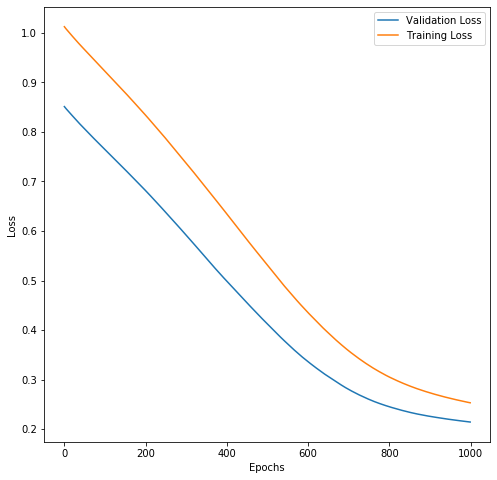

In [12]:
plot_loss(history)

# Task 7: Predictions

## 7.1: Plot Raw Predictions

Let's use the `compare_predictions` helper function to compare predictions from the model when it was untrained and when it was trained.

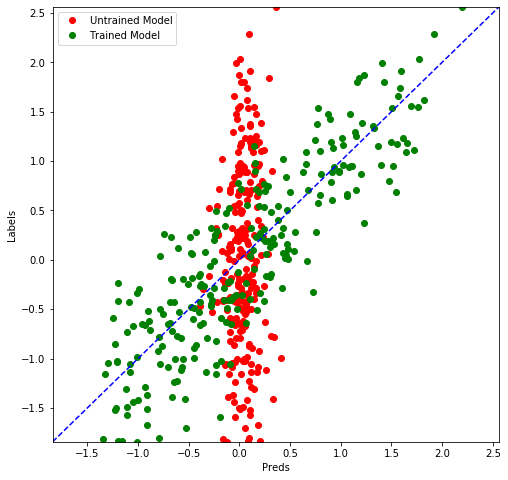

In [13]:
preds_on_trained = model.predict(X_test)

compare_predictions(preds_on_untrained, preds_on_trained, y_test)

## 7.2: Plot Price Predictions

The plot for price predictions and raw predictions will look the same with just one difference: The x and y axis scale is changed.

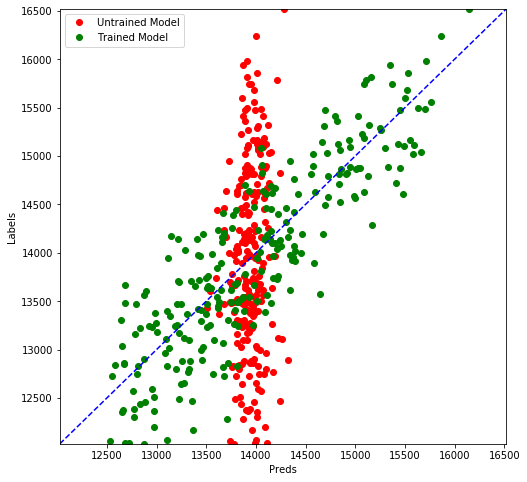

In [14]:
price_on_untrained = [convert_label_value(y) for y in preds_on_untrained]
price_on_trained = [convert_label_value(y) for y in preds_on_trained]
price_y_test = [convert_label_value(y) for y in y_test]

compare_predictions(price_on_untrained, price_on_trained, price_y_test)